## BTC/USD Forecasting with LSTMs

##### Short dataset description
Dataset was sourced from : https://www.cryptodatadownload.com/data/bitfinex/. It cointains hourly historical data of the pair BTC/USD. Data are retrieved from Bitfinex (crypto cex). The columns of the data contain :

1) **open** price of the hourly candle
2) **close** price of the hourly candle
3) **low** price (min) of the hourly candle
4) **high** price (max) of the hourly candle
5) **volume** volume during the candle denominated in the respective currency (**btc/usd**)
6) **symbol** --> btc/usd
7) **unix timestamp**
8) **date**

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder

#### Read the data

In [101]:
df = pd.read_csv('Bitfinex_BTCUSD_1h.csv')
df['date'] = pd.to_datetime(df['date'])
#df['year'] = df['date'].dt.year
#df['month'] = df['date'].dt.month
#df['day'] = df['date'].dt.day
#df['hour'] = df['date'].dt.hour
df = df.drop(["unix", "symbol"], axis = 1)
df = df.sort_values(by='date')

In [102]:
df.head()

,date,open,high,low,close,Volume USD,Volume BTC,year
44624,2018-05-15 06:00:00,8723.8,8793.0,8714.9,8739.0,8988053.53,1026.35,2018
44623,2018-05-15 07:00:00,8739.0,8754.8,8719.3,8743.0,2288904.12,261.97,2018
44622,2018-05-15 08:00:00,8743.0,8743.1,8653.2,8723.7,8891773.14,1023.31,2018
44621,2018-05-15 09:00:00,8723.7,8737.8,8701.2,8708.1,2054868.28,235.55,2018
44620,2018-05-15 10:00:00,8708.1,8855.7,8695.8,8784.4,17309722.58,1969.08,2018


#### Visualization 

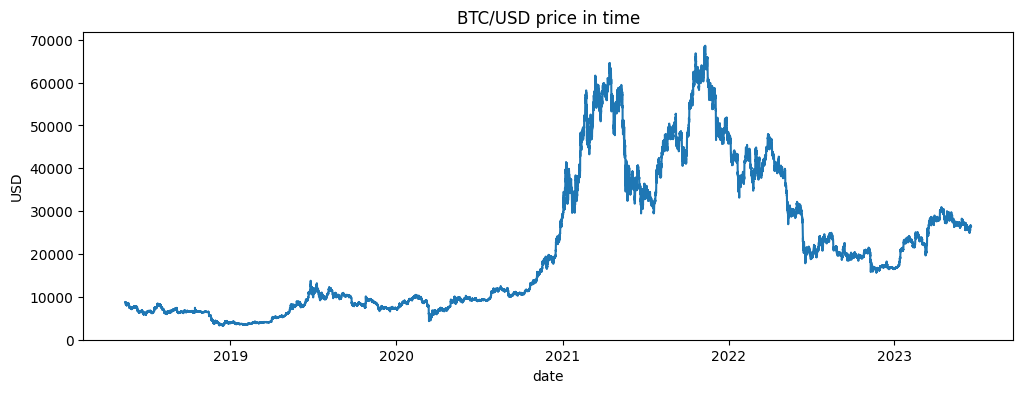

In [103]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['close'])

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')

# Displaying the plot
plt.show()

### Create Training and Test Set

#### Visualize test set

In [104]:
df_test = df.loc[(df['date'] >= '2021-11-01')].copy(deep=True)
df_train = df.loc[(df['date'] <= '2021-11-01' )].copy(deep=True)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
df = df.reset_index()


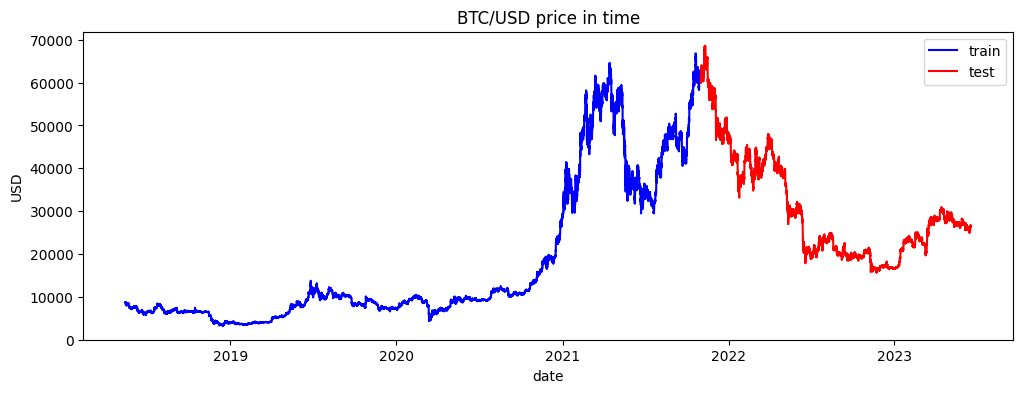

In [105]:
plt.figure(figsize=(12, 4))
plt.plot(df_train['date'], df_train['close'], color = 'blue', label = 'train')
plt.plot(df_test['date'], df_test['close'], color = 'red', label = 'test')

# Adding labels and title
plt.xlabel('date')
plt.ylabel('USD')
plt.title('BTC/USD price in time')
plt.legend()

# Displaying the plot
plt.show()

#### Create the sets

In [106]:
print("Train set consists of:", df_train.shape[0], "samples")
print("Test set consists of:", df_test.shape[0], "samples")
print("Test set is ",(df_test.shape[0]/(df_train.shape[0]+df_test.shape[0]))*100,"of the dataset.")

Train set consists of: 30374 samples
Test set consists of: 14252 samples
Test set is  31.93653923721597 of the dataset.


## Task 1 -- Trend Prediction
For this task we consider the trend to be an uptrend (y = 1) if close[t] < open[t+1] and downtrend (y = 0) if close[t] >= open[t+1].

In [107]:
def generate_trend_prediction_set(dataset):

    data = dataset.copy(deep=True)
    l = data.shape[0]
    data['trend'] = [0]*l

    counter = 0
    counter_eq = 0 
    for index,row in data.iterrows():
        if index+1 >= l:
            continue
        if data.loc[index+1]['close'] > row['close']:
            if counter == 0:
                print("First uptrend :",row['date'])
            counter += 1
            data.at[index,'trend'] = 1
        elif data.loc[index+1]['close'] == row['close']:
            counter_eq +=1

    print("Uptrends counted:",counter)
    print("% of Uptrends:",(counter/l)*100)

    print("No trend counted:",counter_eq)
    print("% of no trends:",(counter_eq/l)*100)

    y = data['trend'].values
    data = data.drop(['trend','index','date'], axis = 1)

    return data.values,y

In [108]:
x_train, y_train = generate_trend_prediction_set(df_train)

First uptrend : 2018-05-15 06:00:00
Uptrends counted: 15405
% of Uptrends: 50.71771910186344
No trend counted: 111
% of no trends: 0.3654441298478962


In [109]:
x_test, y_test = generate_trend_prediction_set(df_test)

First uptrend : 2021-11-01 03:00:00
Uptrends counted: 7097
% of Uptrends: 49.7965197866966
No trend counted: 66
% of no trends: 0.46309289924221164


### Normalization

In [110]:
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Hist Gradient Boosting Classifier

In [111]:
model = HistGradientBoostingClassifier(learning_rate=0.05, max_iter=2000, max_depth=15,  min_samples_leaf=9,random_state=32)

In [112]:
model.fit(x_train,y_train)

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=15, max_iter=2000,
                               min_samples_leaf=9, random_state=32)

In [113]:
y_pred = model.predict(x_test)

In [114]:
f1_score(y_test,y_pred, average = 'macro')

0.4689562570742146

#### DNN

In [100]:
encoder = LabelEncoder()
y_train_dnn = encoder.fit_transform(y_train)
y_test_dnn = encoder.transform(y_test)

In [23]:
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_shape = (x_train.shape[1],)))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(2, activation='softmax'))

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25)
model.compile(optimizer='Nadam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.fit(x_train, y_train_dnn, epochs=250, batch_size=256)

Epoch 1/250


119/119 [==============================] - 1s 1ms/step - loss: 0.6965 - accuracy: 0.4998
Epoch 2/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5124
Epoch 3/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6936 - accuracy: 0.5148
Epoch 4/250
119/119 [==============================] - 0s 2ms/step - loss: 0.6932 - accuracy: 0.5156
Epoch 5/250
119/119 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5163
Epoch 6/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5197
Epoch 7/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5203
Epoch 8/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6922 - accuracy: 0.5224
Epoch 9/250
119/119 [==============================] - 0s 932us/step - loss: 0.6919 - accuracy: 0.5205
Epoch 10/250
119/119 [==============================] - 0s 1ms/step - loss: 0.6919 - accuracy: 0.5198

In [26]:
y_pred = model.predict(x_test)

In [27]:
y_pred_vals = list()
for y in y_pred:
    if y[0] >= y[1]:
        y_pred_vals.append(0)
    else:
        y_pred_vals.append(1)

In [28]:
f1_score(y_test_dnn,y_pred_vals, average = 'macro')

0.49069464586647155

#### LSTM 

In [525]:
def create_lstm_dataset(x,y):
    train_seqs = list()
    train_targets = list()

    i = 0 

    for i in range(len(x) - 24):
        seq = x[i:i+24]
        target = y[i:i+24]
        if seq.shape[0] != 24 or target.shape[0] != 24:
            continue
        train_seqs.append(seq)
        train_targets.append(target)


    train_seqs = np.array(train_seqs)
    train_targets = np.array(train_targets)

    return train_seqs,train_targets


In [526]:
x_train_lstm, y_train_lstm = create_lstm_dataset(x_train,y_train)

In [527]:
x_test_lstm, y_test_lstm = create_lstm_dataset(x_test,y_test)

In [528]:
model=Sequential()
model.add(LSTM(250,return_sequences=True,input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]),activation="relu"))
model.add(LSTM(250,activation="relu"))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss="mean_squared_error",optimizer="adam")

In [529]:
model.fit(x_train_lstm, y_train_lstm, epochs=100, batch_size=256)

Epoch 1/100


119/119 [==============================] - 13s 98ms/step - loss: 0.2499
Epoch 2/100
119/119 [==============================] - 12s 104ms/step - loss: 0.2498
Epoch 3/100
119/119 [==============================] - 13s 108ms/step - loss: 0.2497
Epoch 4/100
119/119 [==============================] - 13s 110ms/step - loss: 0.2496
Epoch 5/100
119/119 [==============================] - 13s 110ms/step - loss: 0.2495
Epoch 6/100
119/119 [==============================] - 13s 107ms/step - loss: 0.2493
Epoch 7/100
119/119 [==============================] - 12s 103ms/step - loss: 0.2490
Epoch 8/100
119/119 [==============================] - 13s 113ms/step - loss: 0.2487
Epoch 9/100
119/119 [==============================] - 13s 112ms/step - loss: 0.2484
Epoch 10/100
119/119 [==============================] - 13s 111ms/step - loss: 0.2481
Epoch 11/100
119/119 [==============================] - 13s 110ms/step - loss: 0.2478
Epoch 12/100
119/119 [==============================] - 13s 108ms/step - los

In [530]:
y_pred = model.predict(x_test_lstm)

In [531]:
y_pred = np.where(y_pred < 0.5, 0, 1)

In [532]:
y_pred.shape

(14228, 1)

In [533]:
y_test.shape

(14252,)

In [534]:
pred = list()
for y in y_pred:
    pred.append(y[0])

In [535]:
f1_score(y_test[:14228], pred)

0.5712723295661685